# Utility Tutorial: Using the Fault Analysis Module
***
In this tutorial, we guide you through the use of the GemPy utility `fault_analysis`. This module provides a mostly voxel-based approach to analyze the effect of faults on lithologies in our model. The most important functions return information or visualizations on:
- the contact of lithologies with the fault surface on hanging or footwall side
    - this includes top and bottom edges of the contact, thichkness of the contact, peaks of the contact, etc.
- fault throw
    - this also allows for a simple calculation of the Shale Smear Factor (SSF)
- juxtaposition of lithologies with themselves or other lithologies of interest
    - this includes visualizations in form of a simplified Allan Diagram plot

Such knowledge can be useful to understand fault-related complexities in our models. Especially fault throw magnitudes and juxtapositional situations might be of relevance for several fields of applications, as they may return valuable information on cross-fault sealing potential and fluid migration pathways. These are important aspects to consider regarding reservoir models in general (aquifers, hydrocarbon accumulations, CCS prospects).

Note: All the functions presented here are deemed to be working realiably in most cases. However, some still require refinement, especially visualization methods, or can be easily adapted for particular utilizations.

We look at three (?) examples:
- Example I: An anticlinal structure cut by one infinite normal fault.
- Example II: The same model with a finite fault. (?)
- Example III: A more complex model including several faults with different strike angles. (?)
***

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize
figsize(15, 6)

# Import the utility module
import gempy.utils.fault_analysis as fa

../../gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


## Example I: Normal faulted and anticlinally deformed lithologies
This ynthetic model comprises several lithological units in one series, presenting anticlinal deformation and normal faulting. A reservoir trap could be defined by seal dipping on one side and by the fault, i.e. juxtaposition with a sealing unit, on the other side.

We construct and compute the model as usual:

In [2]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = os.pardir+"/input_data/NormalFault_AnticlinalTrap_O.csv",
                         path_i = os.pardir+"/input_data/NormalFault_AnticlinalTrap_P.csv")

# Define that we have one fault in our model
geo_data.n_faults = 1

# Assigning series to formations and orders 
gp.set_series(geo_data, {"fault":'NormalFault', 
                      "Rest":('Overlying', 'Sandstone2', 'Shale', 'Sandstone')},
                       order_series = ["fault","Rest",], order_formations=['NormalFault', 
                                         'Overlying', 'Sandstone2', 'Shale', 'Sandstone',
                                         ])

In [3]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], dtype ='float64',
                                 compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [4]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [5]:
lith_block   = lith_sol[0] # lithology block
lith_scalar  = lith_sol[1] # lithology scalar field 

fault_block  = fault_sol[0] # fault block  
fault_scalar = fault_sol[1] # faultscalar field 

# Getting the fault formation number
fault_n = geo_data.formations.loc['NormalFault','formation_number']
shale_n = geo_data.formations.loc['Shale','formation_number']
sst_n   = geo_data.formations.loc['Sandstone','formation_number']

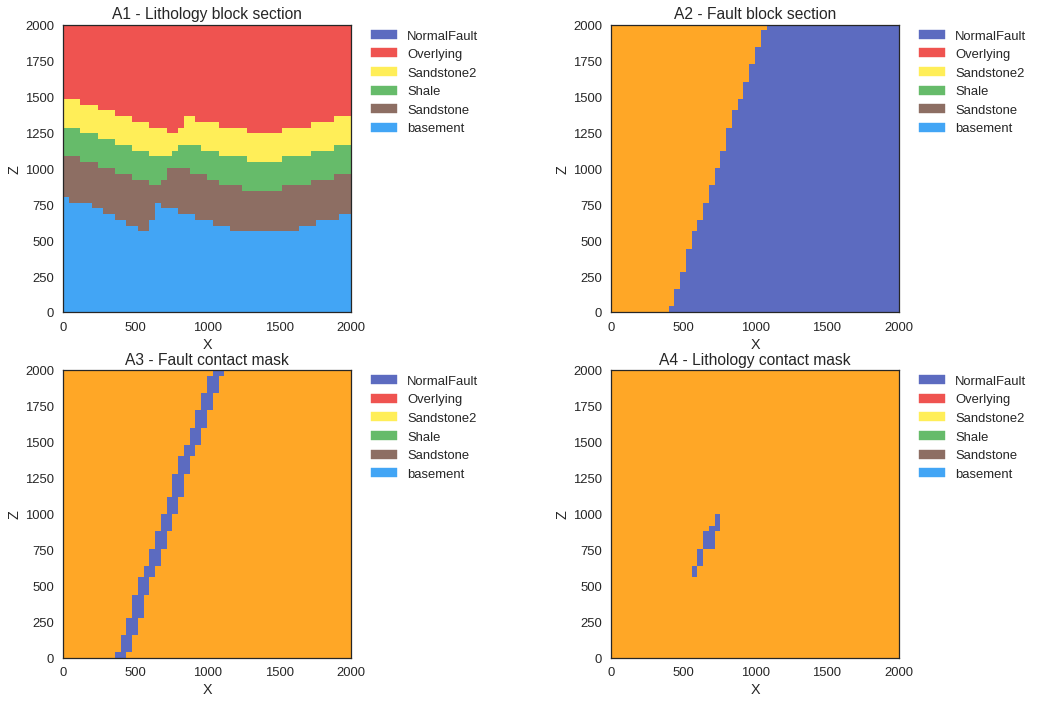

In [8]:
# Plotting sections of our lithology block (lith_sol[0])
figsize(18,18)

plt.subplot(321)
plt.title('A1 - Lithology block section')
gp.plotting.plot_section(geo_data, lith_block, 25, direction='y')

plt.subplot(322)
plt.title('A2 - Fault block section')
gp.plotting.plot_section(geo_data, fault_block-1, 25, direction='y')

plt.subplot(323)
plt.title('A3 - Fault contact mask')
mask = fa.get_fault_mask(geo_data, fault_sol, fault_n, fault_side='both')
gp.plotting.plot_section(geo_data, mask, 25, direction='y')

plt.subplot(324)
plt.title('A4 - Lithology contact mask')
lith_block = np.round(lith_block)
lith_cond = lith_block.reshape(geo_data.resolution[0], geo_data.resolution[1], geo_data.resolution[1]) == sst_n
lith_contact_bool = np.logical_and(lith_cond, mask)
gp.plotting.plot_section(geo_data, lith_contact_bool, 25, direction='y')

In [32]:
contact0 = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n=sst_n, fault_n=fault_n, fault_side='footwall')
maxline = fa.get_extrema_line_voxels(contact0, extrema_type='max')
minline = fa.get_extrema_line_voxels(contact0, extrema_type='min')
contact_proj = (fa.project_voxels(contact0))

In [55]:
figsize(5,5)
im_array = np.zeros_like(contact_proj).astype(int)
im_array[contact_proj] = 150
im_array[maxline] = 100
im_array[minline] = 50

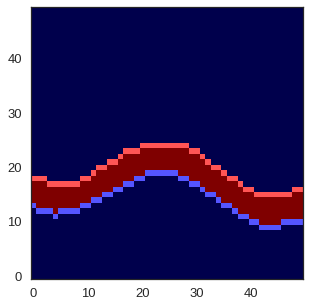

In [58]:
plt.imshow(im_array.T, origin='bottom', cmap='seismic');

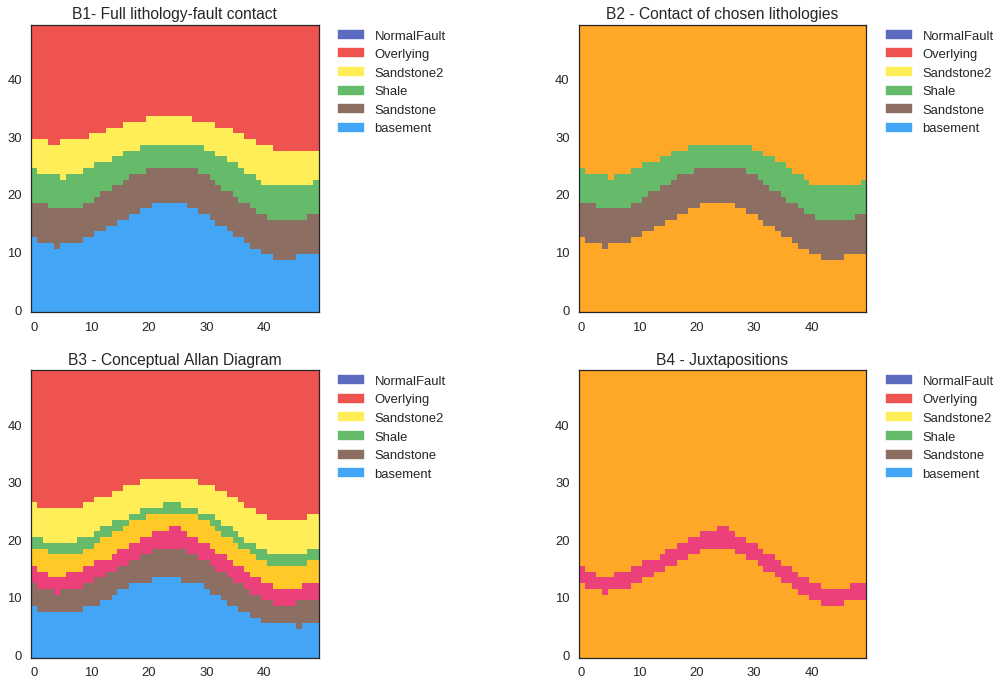

In [9]:
fault_plot = fa.PlotFault2D(geo_data)

figsize(18,18)

plt.subplot(321)
plt.title('B1- Full lithology-fault contact')
fault_plot.plot_lith_fault_contact_full(lith_sol, fault_sol, fault_n, fault_side='footwall')

plt.subplot(322)
plt.title('B2 - Contact of chosen lithologies')
fault_plot.plot_lith_fault_contact(lith_sol, fault_sol, fault_n, lith_n=[shale_n, sst_n], fault_side='footwall')

plt.subplot(323)
plt.title('B3 - Conceptual Allan Diagram')
fault_plot.plot_AllanDiagram(lith_sol, fault_sol, fault_n, lith_target=[sst_n], lith_jux=[sst_n], target_side='fw')

plt.subplot(324)
plt.title('B4 - Juxtapositions')
fault_plot.plot_juxtapositions(lith_sol, fault_sol, fault_n, lith_target=[sst_n], lith_jux=[sst_n], target_side='fw');

In [18]:
contact_peaks = fa.get_contact_peaks_VOX(geo_data, lith_sol, fault_sol, lith_n=sst_n, fault_n=fault_n, fault_side='footwall', \
                              order = 40) 
print(contact_peaks.T)

[[20 21 22 23 24 25 26 27 28]
 [24 24 24 24 24 24 24 24 24]]


In [20]:
peak_faultthrows = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n=sst_n, fault_n=fault_n, \
                           position='faultmax_argrelmax', order = 40)
print(peak_faultthrows)

[[ 160.  120.  120.  120.   80.   80.  120.  160.  160.]]


In [26]:
peak_thicknesses = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n=sst_n, fault_n=fault_n, \
                           fault_side='fw', position='faultmax_argrelmax', order = 40)
print(peak_thicknesses)

[[ 240.  200.  200.  200.  200.  200.  200.  240.  240.]]
